# Setup

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
import yaml
import re
import glob
import metaworld
from scipy.signal import savgol_filter

/home/sbahl2/.conda/envs/drqv2/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [2]:
def get_seed_from_filename(filename):
    pattern_regex = f"(\d)_(\d\d)_(19|20)\d\d.(0[1-9]|1[012]).(0[1-9]|[12][0-9]|3[01])"
    search = re.search(pattern_regex, filename)
    if search is None:
        return None
    return int(search.group(2))

def filter_duplicate_seeds(file_names):
    file_names = sorted(file_names)
    filtered_names = {}
    for name in file_names:
        seed = get_seed_from_filename(name)
        filtered_names[seed] = name
    return list(filtered_names.values())

def get_exp_runs_from_id(id, mode='eval', min_run_length=0):
    file_names = sorted(glob.glob(f'../exp_local/{id}_*/{mode}.csv'))
    file_names = filter_duplicate_seeds(file_names)
    all_runs = []
    for file_name in file_names:
        data = pd.read_csv(file_name)
        if len(data) >= min_run_length:
            all_runs.append(data)
        
    return all_runs

def get_exp_runs_from_dir(exp_dir, mode='eval', min_run_length=0):
    all_run_dirs = os.listdir(exp_dir)
    all_runs = []
    for run_dir in all_run_dirs:
        if mode == 'eval':
            file_dir = exp_dir + "/" + run_dir + "/" + "eval.csv"
        elif mode == 'train':
            file_dir = exp_dir + "/" + run_dir + "/" + "train.csv"
        else:
            raise NotImplementedError
        data = pd.read_csv(file_dir)
        if len(data) >= min_run_length:
            all_runs.append(data)
        
    return all_runs


def get_avg_and_std_across_runs(attr_name, id=None, exp_dir=None, mode='eval', min_run_length=0, smoothing=0):
    assert id is not None or exp_dir is not None, "Either id or exp_dir must be specified"
    if id is not None:
        all_run_data = get_exp_runs_from_id(id=id, mode=mode, min_run_length=min_run_length)
    else:
        all_run_data = get_exp_runs_from_id(exp_dir=exp_dir, mode=mode, min_run_length=min_run_length)
    min_run_length = min([len(run) for run in all_run_data])

    time =  all_run_data[0]["frame"][:min_run_length]

    attr_not_in_runs = [attr_name not in run for run in all_run_data]
    if np.any(attr_not_in_runs):
        return time, None, None

    attr_data = [run[attr_name][:min_run_length] for run in all_run_data]

    average = np.average(attr_data, axis=0)
    std_dev = np.std(attr_data, axis=0) / np.sqrt(len(attr_data))

    if smoothing > 0:
        average = savgol_filter(average, smoothing, 2)
        std_dev = savgol_filter(std_dev, smoothing, 2)

    return time, average, std_dev
    
def plot_attr_across_experiments(attr_name, ids=None, exp_dirs=None, mode='eval', labels=None, 
                                 title=None, min_run_length=0, xlim=None, ylim=None, ax=None, smoothing=0):
    assert ids is not None or exp_dirs is not None, "Either id or exp_dir must be specified"

    if ax is None:
        ax = plt.gca()

    num_plots = len(ids) if ids is not None else len(exp_dirs)

    for idx in range(num_plots):
        if ids is not None:
            time, avg, std = get_avg_and_std_across_runs(attr_name, id=ids[idx], mode=mode, min_run_length=min_run_length, smoothing=smoothing)
        else:
            time, avg, std = get_avg_and_std_across_runs(attr_name, exp_dir=exp_dirs[idx], mode=mode, min_run_length=min_run_length, smoothing=smoothing)
        
        if avg is None:
            continue

        if labels is not None:
            ax.plot(time, avg, label=labels[idx])
        else:
            ax.plot(time, avg)
        ax.fill_between(time, avg-std, avg+std, alpha=0.2)
    
    if labels is not None:
        ax.legend()
    
    if title is not None:
        ax.set_title(title)
    
    if xlim is not None:
        ax.set_xlim(xlim)
    
    if ylim is not None:
        ax.set_ylim(ylim)
    
    ax.set_xlabel("Frames")
    ax.set_ylabel(attr_name)
        

<>:2: DeprecationWarning: invalid escape sequence \d


# Manual Analysis

In [ ]:
# For reference
train_cols = ['actor_ent','actor_logprob','actor_loss','batch_reward','buffer_size',
              'critic_loss','critic_q1','critic_q2','critic_target_q','episode',
              'episode_length','episode_reward','fps','frame','last_success','mask_loss',
              'max_success','mean_success','reconstruction_loss','step','total_time']

eval_cols = ['episode','episode_length','episode_reward','frame','last_success',
             'max_success','mean_success','step','total_time']

In [ ]:
attr_name = "max_success"
mode = 'eval'
plt.figure()
ids = [119, 171]
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=ids, smoothing=0)

# 19-98 - MT1 Experiments

In [ ]:
fig, axes = plt.subplots(6, 7, figsize=(38, 19))
attr = "mean_success"
mode = "eval"
for i in range(19, 99, 2):
    row, col = divmod(int((i-19)//2), 7)

    title = metaworld.MT1.ENV_NAMES[int((i-19)//2)]
    ids = [i, i+1]
    ax = axes[row, col]
    plot_attr_across_experiments(attr, ids=ids, mode=mode, title=title, 
                                  xlim=(0, 2.5e6), ylim=(0, 1), ax=ax)

plot_attr_across_experiments(attr, ids=[19], mode=mode, xlim=(0, 2.5e6), ax=axes[5,5])
plot_attr_across_experiments(attr, ids=[19], mode=mode, xlim=(0, 2.5e6), ax=axes[5,6])

for row in range(6):
    for col in range(7):
        if row < 5:
            ax = axes[row, col]
            ax.set_xlabel(None)
            ax.get_xaxis().set_visible(False)

        if col > 0:
            ax.set_ylabel(None)
            ax.get_yaxis().set_visible(False)

# 162,163,164,171,172 - Decoder to Critic Sweep

In [ ]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
attr = "mean_success"
mode = "eval"
titles = ["mask_loss_coeff=2.5e-5, reconstruction_loss_coeff=1e-4",
          "mask_loss_coeff=2.5e-4, reconstruction_loss_coeff=1e-3", 
          "mask_loss_coeff=2.5e-3, reconstruction_loss_coeff=1e-2", 
          "mask_loss_coeff=2.5e-2, reconstruction_loss_coeff=1e-1", 
          "mask_loss_coeff=2.5e-1, reconstruction_loss_coeff=1",
          "mask_loss_coeff=2.5, reconstruction_loss_coeff=1e1"]
for i, id in enumerate([162, 163, 164, 170, 171, 172]):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    title = titles[i]
    plot_attr_across_experiments(attr, ids=[119, id], mode=mode, 
                                  xlim=(0, 2.5e6), ax=ax, title=title, smoothing=15)

for row in range(nrows-1):
    for col in range(ncols):
        ax = axes[row, col]
        ax.set_xlabel(None)
        ax.get_xaxis().set_visible(False)


In [ ]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))
mode = "train"
labels = ["mask_loss_coeff=2.5e-5, reconstruction_loss_coeff=1e-4",
          "mask_loss_coeff=2.5e-4, reconstruction_loss_coeff=1e-3", 
          "mask_loss_coeff=2.5e-3, reconstruction_loss_coeff=1e-2", 
          "mask_loss_coeff=2.5e-2, reconstruction_loss_coeff=1e-1", 
          "mask_loss_coeff=2.5e-1, reconstruction_loss_coeff=1",
          "mask_loss_coeff=2.5, reconstruction_loss_coeff=1e1"]
ax = axes[0]
plot_attr_across_experiments("mask_loss", ids=[162, 163, 164, 170, 171, 172], mode=mode, 
                                xlim=(0, 2.5e6), ax=ax, labels=labels, ylim=(600, 1200))

ax = axes[1]
plot_attr_across_experiments("reconstruction_loss", ids=[162, 163, 164, 170, 171, 172], mode=mode, 
                                xlim=(0, 2.5e6), ax=ax, labels=labels, ylim=(200, 400))


# 174-181 Adroit Hand Suite

In [ ]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(21, 14))
attr = "mean_success"
mode = "eval"
labels = ["DrQv2",
          "V1"]
titles = ["Adroit Hammer", "Adroit Pen", "Adroit Relocate", "Adroit Human"]
for i, id in enumerate(range(174,178)):
    row, col = divmod(int((i)), ncols)
    ax = axes[row, col]
    plot_attr_across_experiments(attr, ids=[id, id+4], mode=mode, title=titles[i], 
                                  xlim=(0, 2.5e6), ylim=(0, 1), ax=ax, labels=labels, smoothing=0)
for row in range(nrows-1):
    for col in range(ncols):
        ax = axes[row, col]
        ax.set_xlabel(None)
        ax.get_xaxis().set_visible(False)


# 182-183 - V2 and V3 on MT10

In [ ]:
attr = "mean_success"
mode = "eval"
labels = ["DrQv2",
          "V1",
          "V2",
          "V3"]
plot_attr_across_experiments(attr, ids=[119, 171, 182,183], mode=mode, title="MT10 Mean Success", 
                                xlim=(0, 2.5e6), ylim=(0, 1), labels=labels, smoothing=15)


# 188-192 - Latent Dim Sweep

In [ ]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
attr = "mean_success"
mode = "eval"
titles = ["latent dim = 512",
          "latent dim = 1024", 
          "latent dim = 2048", 
          "latent dim = 4096", 
          "latent dim = 8192"]
for i, id in enumerate(list(range(188, 193))):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    title = titles[i]
    plot_attr_across_experiments(attr, ids=[119, id], mode=mode, 
                                  xlim=(0, 2.5e6), ax=ax, title=title, smoothing=15)

plot_attr_across_experiments(attr, ids=[119] + list(range(188, 193)), mode=mode, 
                                  xlim=(0, 2.5e6), ax=axes[-1, -1], labels=["119"] + titles, smoothing=15)         

for row in range(nrows-1):
    for col in range(ncols):
        ax = axes[row, col]
        ax.set_xlabel(None)
        ax.get_xaxis().set_visible(False)

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))
mode = "train"
labels = ["latent dim = 512",
          "latent dim = 1024", 
          "latent dim = 2048", 
          "latent dim = 4096", 
          "latent dim = 8192"]
ax = axes[0]
plot_attr_across_experiments("mask_loss", ids=list(range(188, 193)), mode=mode, 
                                xlim=(0, 2.5e6), ax=ax, labels=labels, ylim=(1250, 1700))

ax = axes[1]
plot_attr_across_experiments("reconstruction_loss", ids=list(range(188, 193)), mode=mode, 
                                xlim=(0, 2.5e6), ax=ax, labels=labels, ylim=(200, 300))


# 193-196 - Kitchen

In [ ]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))
mode = "eval"
attr = "episode_reward"
labels = ["DrQv2", "V1"]
ax = axes[0]
plot_attr_across_experiments(attr, ids=[193,194], mode=mode, title="kitchen-complete-v0",
                                xlim=(0, 2.5e6), ax=ax, labels=labels)

ax = axes[1]
plot_attr_across_experiments(attr, ids=[195,196], mode=mode, title="kitchen-mixed-v0",
                                xlim=(0, 2.5e6), ax=ax, labels=labels)

# 197-198 - Custom MT10 (Different Tasks)

In [ ]:
# Plot experiments grouped by id
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))

attr_name = "mean_success"
mode = 'eval'
plt.figure()
ids = [197, 198]
labels = ['DrQv2', "Agent V1"]
title = 'Custom MT10'
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title, ax=axes[0])
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title + " (Smoothing = 15)", ax=axes[1], smoothing=15)

# 205, 207 - MT3

In [ ]:
# Plot experiments grouped by id
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))

attr_name = "mean_success"
mode = 'eval'
plt.figure()
ids = [205, 207]
labels = ['DrQv2', "Agent V1"]
title = 'Custom MT3'
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title, ax=axes[0])
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title + " (Smoothing = 15)", ax=axes[1], smoothing=15)

# 206, 208 - Custom MT5

In [ ]:
# Plot experiments grouped by id
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))

attr_name = "mean_success"
mode = 'eval'
plt.figure()
ids = [206, 208]
labels = ['DrQv2', "Agent V1"]
title = 'Custom MT5'
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title, ax=axes[0])
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title + " (Smoothing = 15)", ax=axes[1], smoothing=15)

# 209-210 - MT Door Tasks

In [ ]:
# Plot experiments grouped by id
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))

attr_name = "mean_success"
mode = 'eval'
plt.figure()
ids = [209, 210]
labels = ['DrQv2', "Agent V1"]
title = '4 Metaworld Door Tasks'
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title, ax=axes[0])
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title + " (Smoothing = 15)", ax=axes[1], smoothing=15)

# 211 - Drqv2 with pool encoder (latent dim = 512)

In [ ]:
# Plot experiments grouped by id
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))

attr_name = "mean_success"
mode = 'eval'
plt.figure()
ids = [119, 188, 211]
labels = ['DrQv2 (119)', "Agent V1 (188)", "DrQv2 with Pool Encoder (211)"]
title = 'Adding Pool Encoder to DrQv2'
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title, ax=axes[0])
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title + " (Smoothing = 15)", ax=axes[1], smoothing=15)

# 212-251 - V1 Agent on all MT1 Tasks to get BC Expert

In [ ]:
not_included = ["reach-v2", 
                "push-v2", 
                "pick-place-v2", 
                "door-open-v2", 
                "drawer-open-v2", 
                "drawer-close-v2", 
                "button-press-topdown-v2", 
                "peg-insert-side-v2", 
                "window-open-v2", 
                "window-close-v2"]
all_envs = metaworld.MT1.ENV_NAMES
envs = [name for name in metaworld.MT1.ENV_NAMES if name not in not_included]


fig, axes = plt.subplots(6, 7, figsize=(38, 19))
attr = "mean_success"
mode = "eval"

seed = 10
for i, (id, name) in enumerate(zip(range(212, 248), envs)):   
    row, col = divmod(i, 7) 
    ax = axes[row, col]
    baseline_idx = 19 + 2 * all_envs.index(name)
    plot_attr_across_experiments(attr, ids=[baseline_idx, baseline_idx+1, id], mode=mode, title=name, 
                                  xlim=(0, 2.5e6), ylim=(0, 1), ax=ax, labels=[baseline_idx, baseline_idx+1, id], smoothing=15)

for row in range(6):
    for col in range(7):
        if row < 5:
            ax = axes[row, col]
            ax.set_xlabel(None)
            ax.get_xaxis().set_visible(False)

        if col > 0:
            ax.set_ylabel(None)
            ax.get_yaxis().set_visible(False)

# 199-204 and 252-256 - Transfer (Training initially on original MT10) 

In [ ]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
attr = "mean_success"
mode = "eval"
titles = ["assembly",
          "door-lock", 
          "door-close", 
          "hammer", 
          "dial-turn"]
baselines = [19, 47, 45, 63, 41]
for i, (drqv2_id, V1_id) in enumerate(zip(range(252,257), range(199,204))):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    title = titles[i]
    plot_attr_across_experiments(attr, ids=[drqv2_id, V1_id, baselines[i], baselines[i]+1], mode=mode, 
                                  xlim=(0, 2.5e6), ax=ax, title=title, smoothing=15,
                                  labels=['Transfer DrQv2', 'Transfer V1', 'DrQv2', 'V1'])

for row in range(nrows-1):
    for col in range(ncols):
        ax = axes[row, col]
        ax.set_xlabel(None)
        ax.get_xaxis().set_visible(False)


# 257-266 - Transfer (Training initially on custom version of MT10) Note: Experiments not completed

In [ ]:
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
attr = "mean_success"
mode = "eval"
titles = ["bin-picking",
          "box-close", 
          "basketball", 
          "coffee-pull", 
          "button-press-topdown"]
baselines = [23, 25, 21, 37, 27]
for i, (drqv2_id, V1_id) in enumerate(zip(range(257,262), range(262,267))):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    title = titles[i]
    plot_attr_across_experiments(attr, ids=[drqv2_id, V1_id, baselines[i], baselines[i]+1], mode=mode, 
                                  xlim=(0, 2.5e6), ax=ax, title=title, smoothing=15,
                                  labels=['Transfer DrQv2', 'Transfer V1', 'DrQv2', 'V1'])

for row in range(nrows-1):
    for col in range(ncols):
        ax = axes[row, col]
        ax.set_xlabel(None)
        ax.get_xaxis().set_visible(False)


# 267-270 - DrQv2AE on Adroit Hand

In [ ]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(21, 14))
attr = "mean_success"
mode = "eval"
titles = ["Adroit Hammer", "Adroit Pen", "Adroit Relocate", "Adroit Door"]
for i, (baseline_id, id) in enumerate(zip(range(174,178), range(267,272))):
    row, col = divmod(int((i)), ncols)
    ax = axes[row, col]
    labels = [f"DrQv2 {baseline_id}",
              f"V1 {baseline_id+4}", 
              f"DrQv2AE {id}"]
    plot_attr_across_experiments(attr, ids=[baseline_id, baseline_id+4, id], mode=mode, title=titles[i], 
                                  xlim=(0, 2.5e6), ylim=(0, 1), ax=ax, labels=labels, smoothing=0)
for row in range(nrows-1):
    for col in range(ncols):
        ax = axes[row, col]
        ax.set_xlabel(None)
        ax.get_xaxis().set_visible(False)


# 271 - DrQv2AE on MT10

In [ ]:
# Plot experiments grouped by id
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))

attr_name = "mean_success"
mode = 'eval'
plt.figure()
ids = [119, 188, 271]
labels = ['DrQv2 119', "Agent V1 188", "DrQv2AE 271"]
title = 'Custom MT10'
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title, ax=axes[0])
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title + " (Smoothing = 15)", ax=axes[1], smoothing=15)

# 272 - DrqV2AE on MT3

In [ ]:
# Plot experiments grouped by id
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))

attr_name = "mean_success"
mode = 'eval'
plt.figure()
ids = [205, 207, 272]
labels = ['DrQv2 205', "Agent V1 207", "DrQv2AE 272"]
title = 'Custom MT3'
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title, ax=axes[0])
plot_attr_across_experiments(attr_name, ids=ids, mode=mode, labels=labels, title=title + " (Smoothing = 15)", ax=axes[1], smoothing=15)

# 273-282 - DrQv2AE on MT1

In [ ]:
envs = ["assembly-v2",
        "bin-picking-v2",
        "box-close-v2",
        "button-press-topdown-wall-v2",
        "button-press-wall-v2",
        "door-close-v2",
        "door-lock-v2",
        "door-open-v2",
        "door-unlock-v2",
        "hammer-v2"]
all_envs = metaworld.MT1.ENV_NAMES

fig, axes = plt.subplots(3,4, figsize=(38, 19))
attr = "mean_success"
mode = "eval"

seed = 10
for i, (id, name) in enumerate(zip(range(273, 283), envs)):   
    row, col = divmod(i, 4) 
    ax = axes[row, col]
    baseline_idx = 19 + 2 * all_envs.index(name)
    labels = [f"DrQv2 {baseline_idx}", f"V1 {baseline_idx+1}", f"DrQv2AE {id}"]
    plot_attr_across_experiments(attr, ids=[baseline_idx, baseline_idx+1, id], mode=mode, title=name, 
                                  xlim=(0, 2.5e6), ylim=(0, 1), ax=ax, labels=labels, smoothing=15)

for row in range(3):
    for col in range(4):
        if row < 5:
            ax = axes[row, col]
            ax.set_xlabel(None)
            ax.get_xaxis().set_visible(False)

        if col > 0:
            ax.set_ylabel(None)
            ax.get_yaxis().set_visible(False)

# 283-288 - Kitchen with random camera

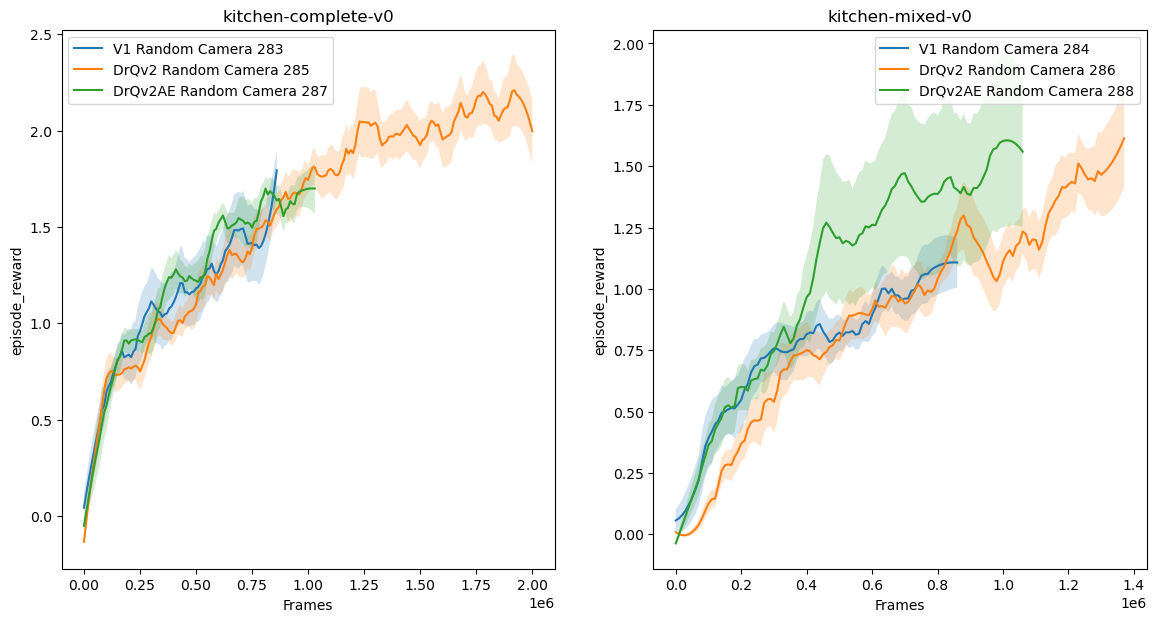

In [12]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))
mode = "eval"
attr = "episode_reward"
labels = ["V1 Random Camera 283", "DrQv2 Random Camera 285", "DrQv2AE Random Camera 287"]
ax = axes[0]
plot_attr_across_experiments(attr, ids=[283, 285, 287], mode=mode, title="kitchen-complete-v0",
                                ax=ax, labels=labels, smoothing=15)

labels = ["V1 Random Camera 284",  "DrQv2 Random Camera 286", "DrQv2AE Random Camera 288"]
ax = axes[1]
plot_attr_across_experiments(attr, ids=[284, 286, 288], mode=mode, title="kitchen-mixed-v0",
                                ax=ax, labels=labels, smoothing=15)

# 289-294 Adroit Hammer Sweep

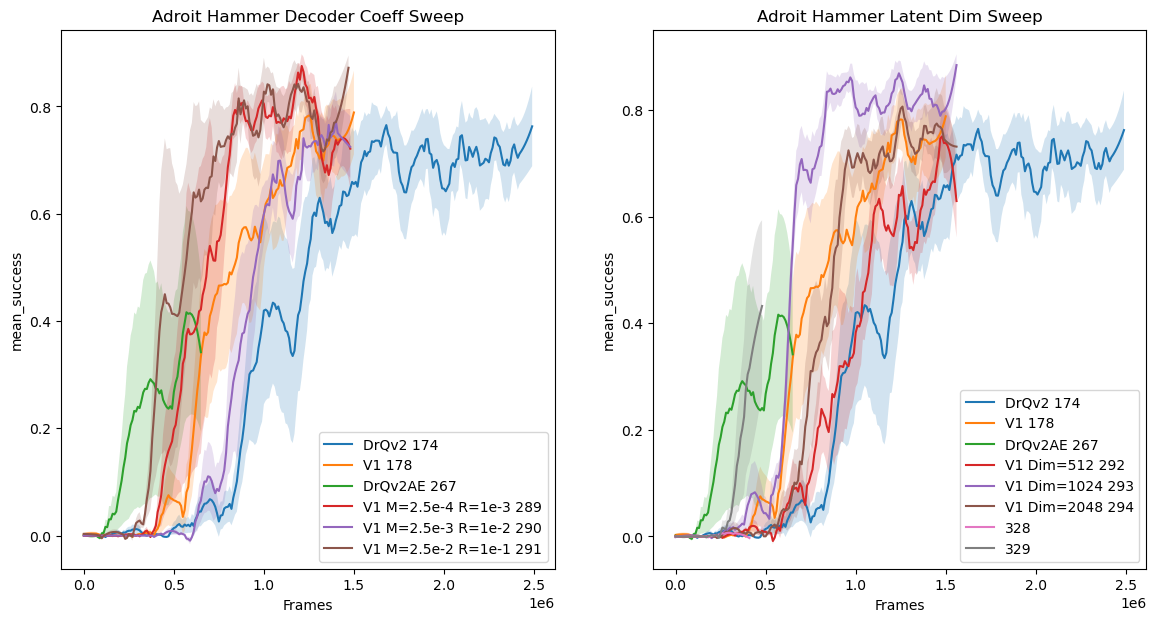

In [6]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 7))
mode = "eval"
attr = "mean_success"
labels = ["DrQv2 174", "V1 178", "DrQv2AE 267", "V1 M=2.5e-4 R=1e-3 289", "V1 M=2.5e-3 R=1e-2 290", "V1 M=2.5e-2 R=1e-1 291"]
ax = axes[0]
plot_attr_across_experiments(attr, ids=[174, 178, 267, 289, 290, 291], mode=mode, title="Adroit Hammer Decoder Coeff Sweep",
                                ax=ax, labels=labels, smoothing=15)

labels = ["DrQv2 174", "V1 178", "DrQv2AE 267", "V1 Dim=512 292", "V1 Dim=1024 293", "V1 Dim=2048 294", "328", "329"]
ax = axes[1]
plot_attr_across_experiments(attr, ids=[174, 178, 267, 292, 293, 294, 328, 329], mode=mode, title="Adroit Hammer Latent Dim Sweep",
                                ax=ax, labels=labels, smoothing=15)

# 320-323 - Kitchen Sweep

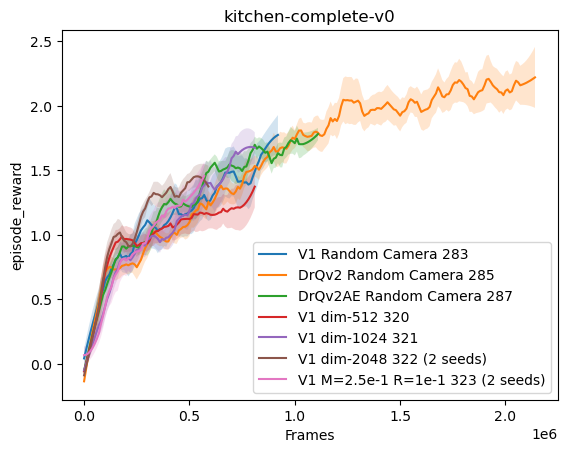

In [5]:
nrows = 1
ncols = 2
mode = "eval"
attr = "episode_reward"
labels = ["V1 Random Camera 283", "DrQv2 Random Camera 285", "DrQv2AE Random Camera 287", "V1 dim-512 320", "V1 dim-1024 321", "V1 dim-2048 322 (2 seeds)", "V1 M=2.5e-1 R=1e-1 323 (2 seeds)"]
plot_attr_across_experiments(attr, ids=[283, 285, 287, 320, 321, 3222, 3232], mode=mode, title="kitchen-complete-v0",
                                labels=labels, smoothing=15)